#Практическая работа №1
##Предварительная обработка данных
Выполнила Фонград Анастасия Андреевна КИ21-16/1б
##Цель работы
Знакомство с основными задачами предварительной обработки исходных данных, изучение основных методов предварительной обработки данных формирование навыков выполнения предварительной обработки исходных данных с помощью языка программирования Python.
##Задачи
Выполнение практической работы предполагает решение следующий задач:
1. Визуальный анализ исходных данных
2. Поиск аномальных значений
3. Поиск и восстановление отсутствующих значений
4. Преобразование данных


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.impute
from scipy.stats import sigmaclip

Был произведён импорт данных из .xlsx файла

In [32]:
data = pd.read_excel("C:\\Users\\fongr\\Documents\\Мои документы\\Второй курс\\python\\scientificProject\\data\\first_practice_dataframe.xlsx", sheet_name="Sheet1")
PROFICIENCY_LEVEL = "cat10_proficiencyLevel"
AGE = "cat9_age"
NUM_1 = "num1_24"
NUM_2 = "num2_24"
NUM_3 = "num3_24"
headers = [PROFICIENCY_LEVEL, AGE, NUM_1, NUM_2, NUM_3]
frame = pd.DataFrame(data[headers])
print(frame)

    cat10_proficiencyLevel            cat9_age      num1_24      num2_24  \
0                 Advanced      below 21 years   907.348256   242.734013   
1                   Novice  59 years and above   962.219776  1035.400665   
2                   Novice  59 years and above  1053.680910  -469.064161   
3                 Advanced  59 years and above  1148.702980  2793.294228   
4                 Advanced  59 years and above  1018.119147  -954.043533   
..                     ...                 ...          ...          ...   
995               Advanced      below 21 years   815.379375  -154.418945   
996                 novice  59 years and above  1195.478914  -572.061291   
997                 Novice      21 to 35 years   762.115010  -596.334731   
998                 Novice  59 years and above   730.372126 -1101.408593   
999               Advanced      36 to 58 years  1015.521911   838.290002   

        num3_24  
0    971.167308  
1    933.449443  
2    950.209325  
3    942.957073

##Визуальный анализ данных
Были построены несколько видов графиков для каждого из столбцов таблицы

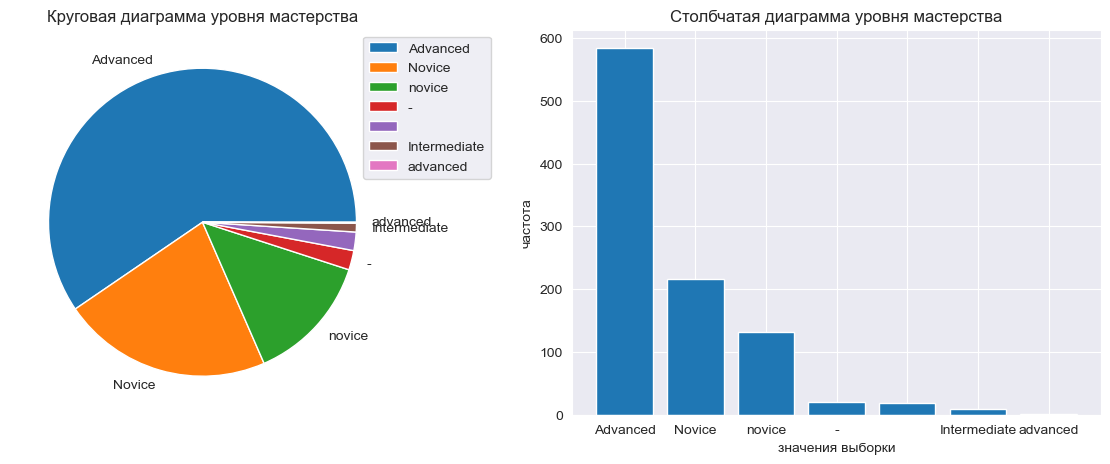

In [33]:
proficiency = frame[PROFICIENCY_LEVEL].value_counts()
fig = plt.figure(figsize=(15, 5))
# Adds subplot on position 1
ax = fig.add_subplot(121)
# Adds subplot on position 2
ax2 = fig.add_subplot(122)
ax.pie(proficiency.values, labels=proficiency.index)
ax.legend(bbox_to_anchor=(0.9, 1))
ax.set_title("Круговая диаграмма уровня мастерства")
ax2.bar(x=proficiency.index, height=proficiency.values)
ax2.set_title("Столбчатая диаграмма уровня мастерства")
plt.setp([ax2], xlabel='значения выборки', ylabel='частота')
plt.show()

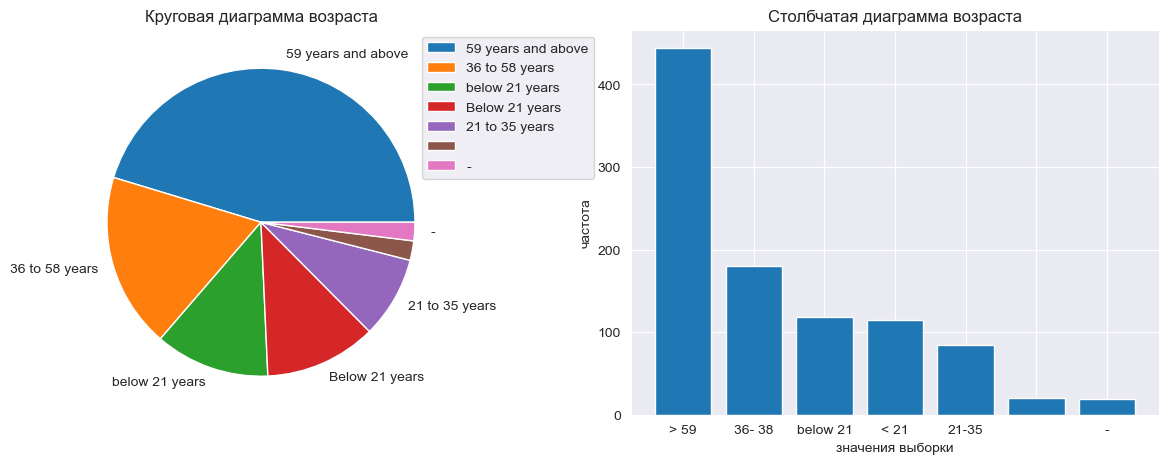

In [34]:
age = frame[AGE].value_counts()
fig = plt.figure(figsize=(15, 5))
# Adds subplot on position 1
ax = fig.add_subplot(121)
# Adds subplot on position 2
ax2 = fig.add_subplot(122)
ax.pie(age.values, labels=age.index)
ax.legend(bbox_to_anchor=(0.9, 1))
ax.set_title("Круговая диаграмма возраста")
ax2.bar(x=age.index, height=age.values)
ax2.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax2.set_xticklabels(['> 59', '36- 38', 'below 21', '< 21', '21-35', "", "-"])
ax2.set_title("Столбчатая диаграмма возраста")
plt.setp([ax2], xlabel='значения выборки', ylabel='частота')
plt.show()

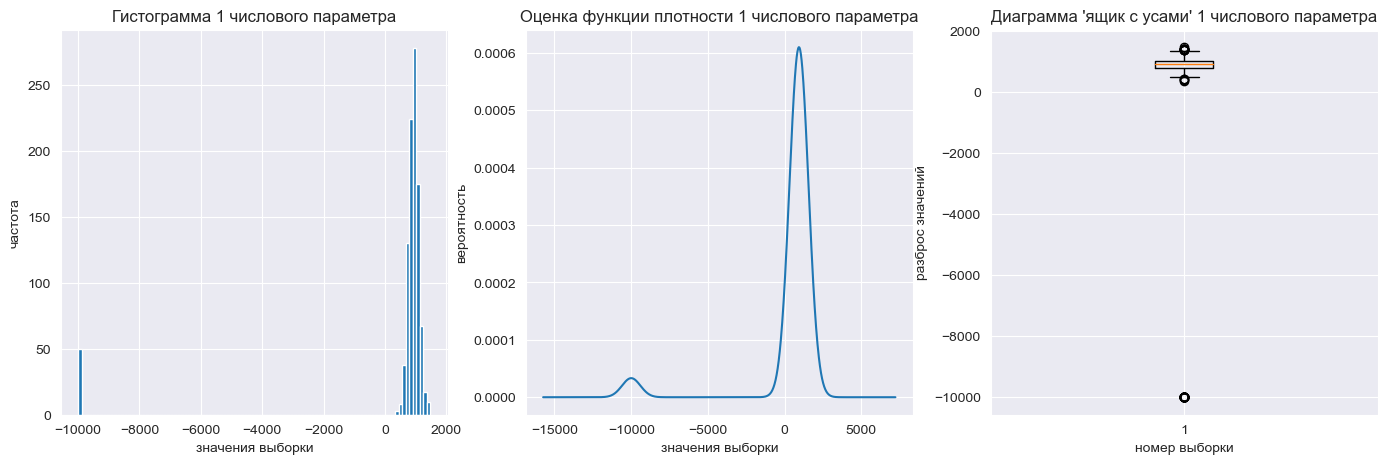

In [37]:
num1 = frame[NUM_1]
n_bins = len(num1)
fig = plt.figure(figsize=(17, 5))
ax = fig.add_subplot(131)
ax2 = fig.add_subplot(133)
ax3 = fig.add_subplot(132)
ax.hist(num1, bins=100)
ax.set_title("Гистограмма 1 числового параметра")
ax2.boxplot(x=num1)
ax3.set_title("Оценка функции плотности 1 числового параметра")
ax2.set_title("Диаграмма 'ящик с усами' 1 числового параметра")
data[NUM_1].plot.kde()
plt.setp([ax, ax3], xlabel='значения выборки')
plt.setp([ax2], xlabel='номер выборки', ylabel='разброс значений')
plt.setp([ax], ylabel='частота')
plt.setp([ax3], ylabel='вероятность')
plt.show()

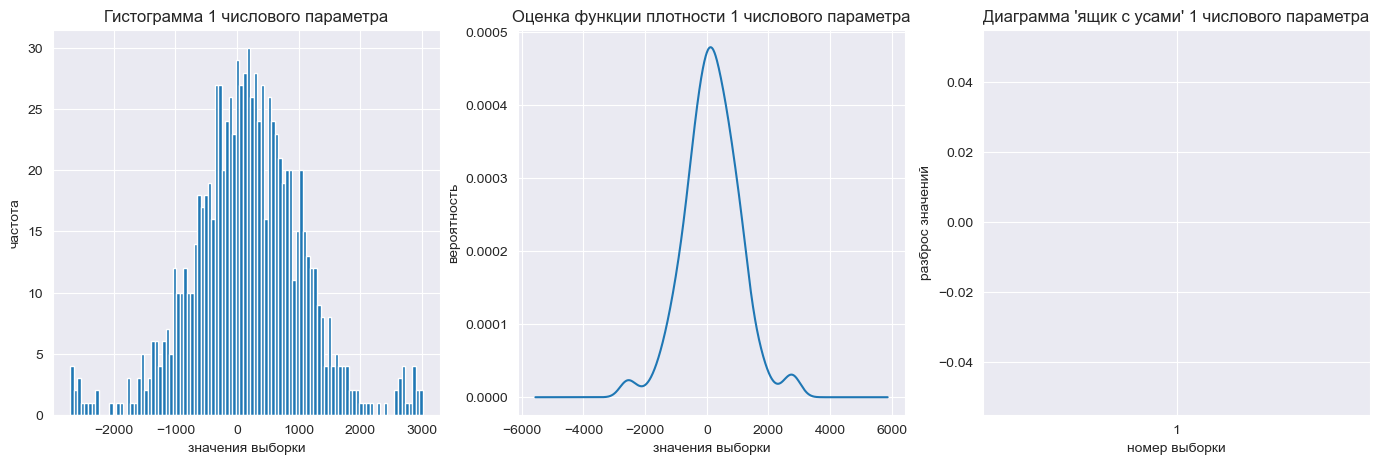

In [38]:
num2 = frame[NUM_2]
# n_bins = len(num2)
fig = plt.figure(figsize=(17, 5))
ax = fig.add_subplot(131)
ax2 = fig.add_subplot(133)
ax3 = fig.add_subplot(132)
ax.hist(num2, bins=100)
ax2.boxplot(x=num2)
num2.plot.kde()
ax.set_title("Гистограмма 1 числового параметра")
ax3.set_title("Оценка функции плотности 1 числового параметра")
ax2.set_title("Диаграмма 'ящик с усами' 1 числового параметра")
plt.setp([ax, ax2, ax3], xlabel='значения выборки')
plt.setp([ax], ylabel='частота')
plt.setp([ax3], ylabel='вероятность')
plt.setp([ax2], xlabel='номер выборки', ylabel='разброс значений')
plt.show()

По графикам видно, что некоторые из значений таблицы являются некорректными. Наблюдаются пропуски значений, выбросы. Значения качественных признаков необходимо привести к единому виду.

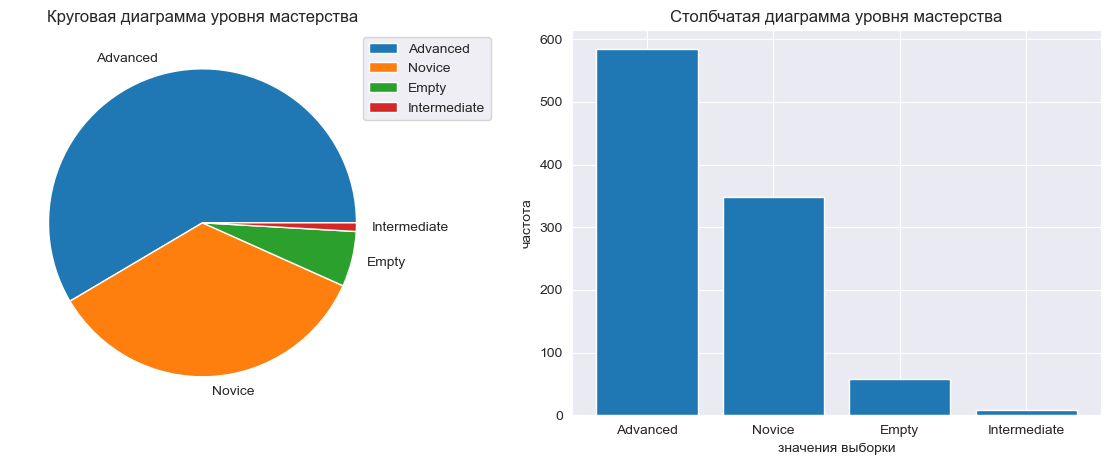

In [35]:
frame.loc[frame[PROFICIENCY_LEVEL]=='-', PROFICIENCY_LEVEL] = "Empty"
frame.loc[frame[PROFICIENCY_LEVEL]=='', PROFICIENCY_LEVEL] = "Empty"
frame.loc[frame[PROFICIENCY_LEVEL]==' ', PROFICIENCY_LEVEL] = "Empty"
frame.loc[frame[PROFICIENCY_LEVEL]=='novice', PROFICIENCY_LEVEL] = "Novice"
frame.loc[frame[PROFICIENCY_LEVEL]=='advanced', PROFICIENCY_LEVEL] = "Advanced"
frame[PROFICIENCY_LEVEL] = frame[PROFICIENCY_LEVEL].fillna("Empty")
proficiency = frame[PROFICIENCY_LEVEL].value_counts()

fig = plt.figure(figsize=(15, 5))

# Adds subplot on position 1
ax = fig.add_subplot(121)
# Adds subplot on position 2
ax2 = fig.add_subplot(122)

ax.pie(proficiency.values, labels=proficiency.index)
ax.legend(bbox_to_anchor=(0.9, 1))
ax.set_title("Круговая диаграмма уровня мастерства")
ax2.bar(x=proficiency.index, height=proficiency.values)
ax2.set_title("Столбчатая диаграмма уровня мастерства")
plt.setp([ax2], xlabel='значения выборки', ylabel='частота')
plt.show()

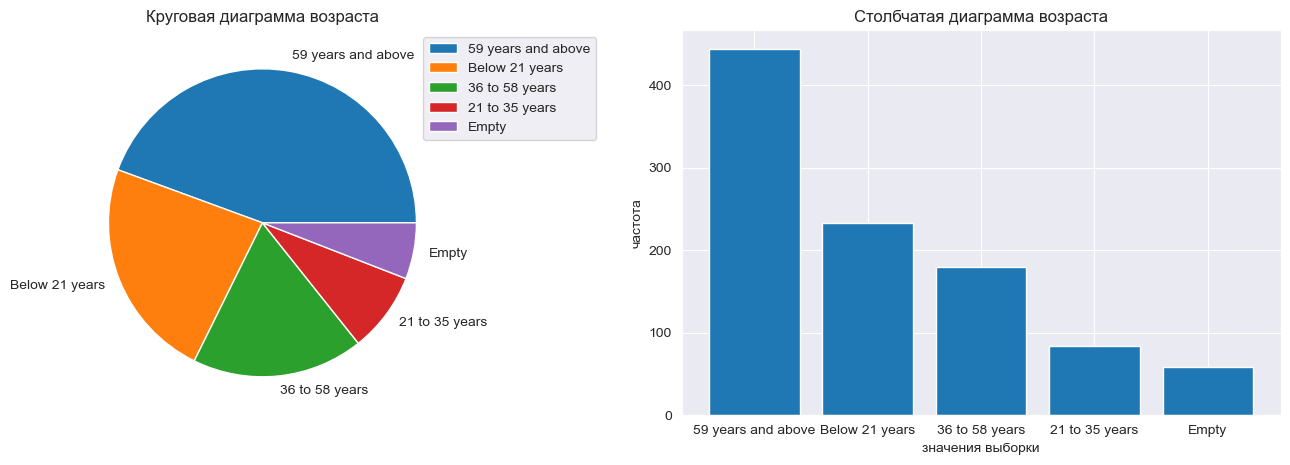

In [36]:
frame.loc[frame[AGE]=='-', AGE] = "Empty"
frame.loc[frame[AGE]=='', AGE] = "Empty"
frame.loc[frame[AGE]==' ', AGE] = "Empty"
frame.loc[frame[AGE]=='below 21 years', AGE] = "Below 21 years"
frame[AGE] = frame[AGE].fillna("Empty")
age = frame[AGE].value_counts()

fig = plt.figure(figsize=(17, 5))

# Adds subplot on position 1
ax = fig.add_subplot(121)
# Adds subplot on position 2
ax2 = fig.add_subplot(122)

ax.pie(age.values, labels=age.index)
ax.legend(bbox_to_anchor=(0.9, 1))
ax.set_title("Круговая диаграмма возраста")
ax2.bar(x=age.index, height=age.values)
ax2.set_title("Столбчатая диаграмма возраста")
plt.setp([ax2], xlabel='значения выборки', ylabel='частота')
plt.show()

In [39]:
frame.loc[frame[NUM_3]=='-', NUM_3] = float('nan')
frame.loc[frame[NUM_3]=='', NUM_3] = float('nan')
frame.loc[frame[NUM_3]==' ', NUM_3] = float('nan')
frame[NUM_3] = frame[NUM_3].fillna(np.NaN)
frame.info()
frame[NUM_3]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cat10_proficiencyLevel  1000 non-null   object 
 1   cat9_age                1000 non-null   object 
 2   num1_24                 1000 non-null   float64
 3   num2_24                 950 non-null    float64
 4   num3_24                 916 non-null    float64
dtypes: float64(3), object(2)
memory usage: 39.2+ KB


0      971.167308
1      933.449443
2      950.209325
3      942.957073
4      947.163814
          ...    
995    961.201375
996    954.136037
997    955.746237
998    953.369459
999    952.558506
Name: num3_24, Length: 1000, dtype: float64

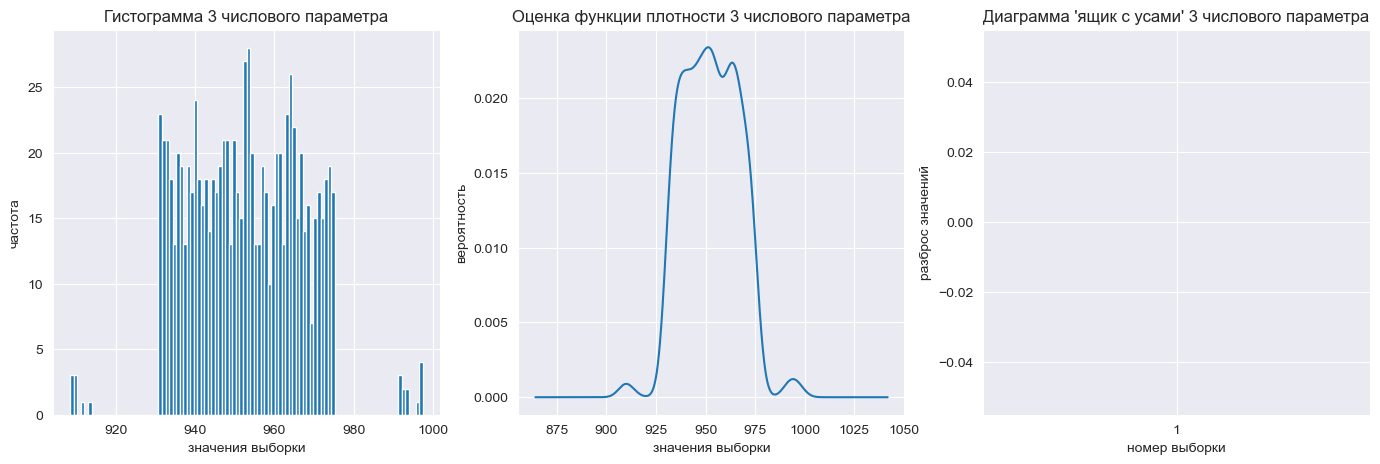

In [40]:
num3 = frame[NUM_3]
# n_bins = len(num2)
fig = plt.figure(figsize=(17, 5))
ax = fig.add_subplot(131)
ax2 = fig.add_subplot(133)
ax3 = fig.add_subplot(132)
ax.hist(num3, bins=100)
ax2.boxplot(x=num3)
num3.plot.kde()
ax.set_title("Гистограмма 3 числового параметра")
ax3.set_title("Оценка функции плотности 3 числового параметра")
ax2.set_title("Диаграмма 'ящик с усами' 3 числового параметра")
plt.setp([ax, ax2, ax3], xlabel='значения выборки')
plt.setp([ax], ylabel='частота')
plt.setp([ax3], ylabel='вероятность')
plt.setp([ax2], xlabel='номер выборки', ylabel='разброс значений')
plt.show()

##Поиск аномальных значений в исходном наборе

In [41]:
def outlier_estimation(value):
    column = num3
    #me = column.median()
    #mo = column.mode().tolist()[0]
    q25 = column.quantile(0.25)
    q75 = column.quantile(0.75)
    delta = q75 - q25
    inside_border = [(q25 - 1.5 * delta), (q75 + 1.5 * delta)]
    outside_border = [(q25 - 3 * delta), (q75 + 3 * delta)]
    print(inside_border, outside_border)
    if value > outside_border[1] or value < outside_border[0]:
        return 2
    elif value > inside_border[1] or value < inside_border[0]:
        return 1
    else:
        return 0

In [42]:
median = frame[NUM_2].median()
frame[NUM_2] = frame[NUM_2].fillna(median)
frame[NUM_3] = frame[NUM_3].fillna(median)
frame.info()
frame.loc[frame[AGE]=="Empty", AGE] = "59 years and above"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cat10_proficiencyLevel  1000 non-null   object 
 1   cat9_age                1000 non-null   object 
 2   num1_24                 1000 non-null   float64
 3   num2_24                 1000 non-null   float64
 4   num3_24                 1000 non-null   float64
dtypes: float64(3), object(2)
memory usage: 39.2+ KB


In [43]:
inputer = sklearn.impute.KNNImputer(n_neighbors=2)
# frame = pd.DataFrame(inputer.fit_transform(frame[NUM_1]),columns = frame)
#inputer.fit_transform(frame[NUM_1])
frame[NUM_1]

0       907.348256
1       962.219776
2      1053.680910
3      1148.702980
4      1018.119147
          ...     
995     815.379375
996    1195.478914
997     762.115010
998     730.372126
999    1015.521911
Name: num1_24, Length: 1000, dtype: float64

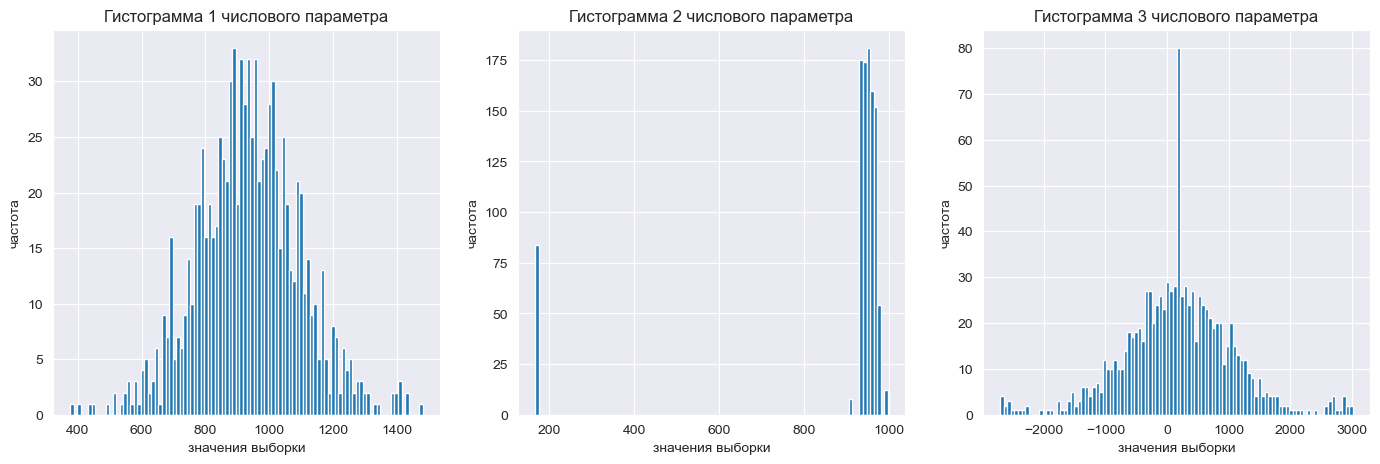

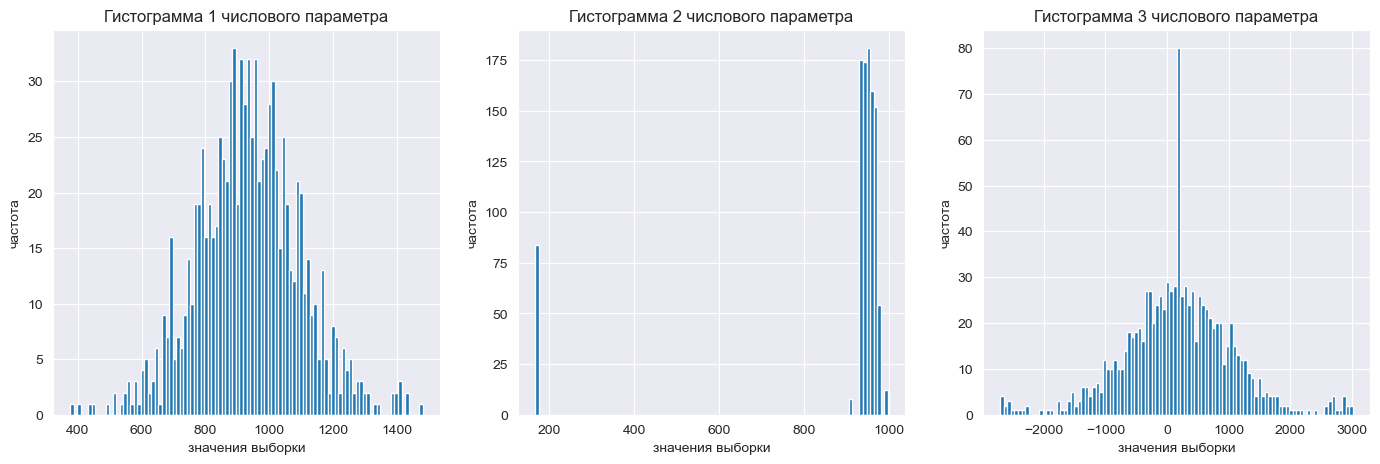

In [44]:
a, b, c = sigmaclip(frame[NUM_1])
d, e, o = sigmaclip(frame[NUM_2])
q, w, p = sigmaclip(frame[NUM_3], 4, 4)
#sigmaclip(frame[NUM_3], 4, 4)
fig = plt.figure(figsize=(17, 5))
ax = fig.add_subplot(131)
ax2 = fig.add_subplot(133)
ax3 = fig.add_subplot(132)
ax.hist(a, bins=100)
ax2.hist(d, bins=100)
ax3.hist(q, bins=100)
ax.set_title("Гистограмма 1 числового параметра")
ax3.set_title("Гистограмма 2 числового параметра")
ax2.set_title("Гистограмма 3 числового параметра")
plt.setp([ax, ax2, ax3], xlabel='значения выборки', ylabel='частота')
plt.show()